In [2]:
import sys
sys.path.append('../..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import seaborn as sns

from scipy import stats

import visualizor

In [3]:
df = pd.read_csv('../../final_data.csv')

C:\Users\marcu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (18,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df = df[(df.commentDateOffset <= 30) & (df.commentDateOffset >= -30)]

118
120


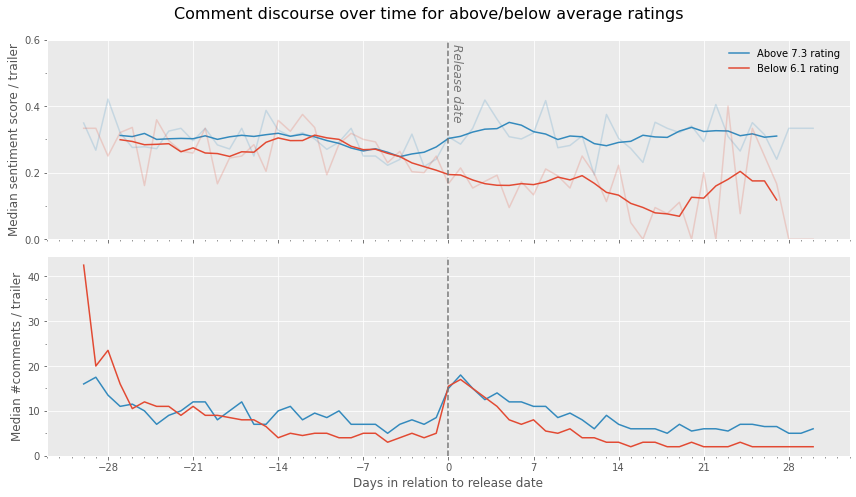

In [50]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,7))
fig.suptitle('Comment discourse over time for above/below average ratings', fontsize=16)

X = df

threshold = X[['tconst', 'averageRating']].drop_duplicates().averageRating.median()

mask = X.averageRating >= threshold
X['threshold'] = mask

offset = .6
X = X[(X.averageRating <= threshold-offset) | (X.averageRating >= threshold+offset)]


annot_params = {
    'color': '#777777',
    'linestyle': '--'
}

plot_dict = {
    True: {
        'color': '#348ABD',
        'label': f'Above {round(threshold + offset, 2)} rating'
    },
    
    False: {
        'color': '#E24A33',
        'label': f'Below {round(threshold - offset, 2)} rating'
    }
}

window_size=7



for condition in X.threshold.unique():
    mask = X.threshold == condition
    print(X[mask].primaryTitle.nunique())
    Xagg = X[mask].groupby(['commentDateOffset', 'videoId', 'primaryTitle']).agg(
        sentiment=('sentimentPredictedScore', 'mean'),
        numComments=('commentId', 'count')
    ).reset_index()
    
    Xagg = Xagg.groupby('commentDateOffset').agg(
        sentiment=('sentiment', 'median'),
        numComments=('numComments', 'median')
    ).reset_index()
    
    trend = Xagg.rolling(window=window_size, center=True).mean().sentiment
   
    trend = ax1.plot(Xagg.commentDateOffset, trend, **plot_dict[condition])
    ax1.plot(Xagg.commentDateOffset, Xagg.sentiment, alpha=.2)
    ax2.plot(Xagg.commentDateOffset, Xagg.numComments)


ax1.set_ylim(0, .6)

ax1.axvline(x=0, **annot_params)
ax1.text(0.1, .36, 'Release date', color=annot_params['color'], fontsize=12, fontstyle='italic', rotation=-90)

ax1.set_ylabel('Median sentiment score / trailer')

ax1.xaxis.set_major_locator(MultipleLocator(7))
ax1.xaxis.set_minor_locator(MultipleLocator(1))

ax1.yaxis.set_major_locator(MultipleLocator(.2))
ax1.yaxis.set_minor_locator(MultipleLocator(.1))
ax1.set_xticklabels([])

    
ax2.axvline(x=0, **annot_params)

ax2.xaxis.set_major_locator(MultipleLocator(7))
ax2.xaxis.set_minor_locator(MultipleLocator(1))

ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(MultipleLocator(5))

ax2.set_xlabel('Days in relation to release date')
ax2.set_ylabel('Median #comments / trailer')

ax1.legend()


plt.tight_layout()

In [51]:
fig.savefig('../../figs/discourse_time.svg')